In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import numpy as np
import pandas as pd

In [5]:
import fastai
print("fastai: ",fastai.__version__)
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

fastai:  1.0.52
Torch:  1.1.0
Torchvision:  0.3.0
sklearn:  0.21.2
Python:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [6]:
!nvidia-smi

Sun May 26 19:42:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.27       Driver Version: 415.27       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   38C    P8    11W / 250W |    480MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

GPU:  GeForce GTX 1080 Ti


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
PATH = Path('../../../../../data/StanfordCars')

In [10]:
import os
print(os.listdir(PATH))

['cars_train', 'cars_annos.mat', 'devkit', 'cars_test', '__MACOSX', 'car_devkit.tgz']


In [11]:
PATH.ls()

[PosixPath('../../../../../data/StanfordCars/cars_train'),
 PosixPath('../../../../../data/StanfordCars/cars_annos.mat'),
 PosixPath('../../../../../data/StanfordCars/devkit'),
 PosixPath('../../../../../data/StanfordCars/cars_test'),
 PosixPath('../../../../../data/StanfordCars/__MACOSX'),
 PosixPath('../../../../../data/StanfordCars/car_devkit.tgz')]

In [12]:
path_train = PATH/'cars_train'
path_test = PATH/'cars_test'

In [13]:
fnames = get_image_files(path_train)
fnames[:5]

[PosixPath('../../../../../data/StanfordCars/cars_train/05858.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/01598.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/01845.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/05269.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/00871.jpg')]

In [44]:
len(fnames)

8144

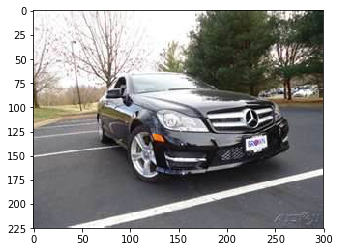

In [14]:
img = plt.imread(fnames[2])
plt.imshow(img);

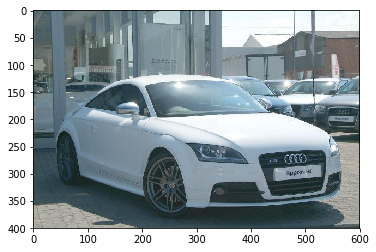

In [15]:
pic = Path('../../../../../data/StanfordCars/cars_train/00001.jpg')
img = plt.imread(pic)
plt.imshow(img);

In [17]:
fnames[:5]

[PosixPath('../../../../../data/StanfordCars/cars_train/05858.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/01598.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/01845.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/05269.jpg'),
 PosixPath('../../../../../data/StanfordCars/cars_train/00871.jpg')]

In [18]:
import scipy.io
cars_annos = scipy.io.loadmat(PATH/'cars_annos.mat')

In [19]:
type(cars_annos)

dict

In [20]:
cars_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000004.jpg'], dtype='<U18'), array([[33]], dtype=uint8), array([[50]], dtype=uint8), array([[197]], dtype=uint8), array([[150]], dtype=uint8), arr

In [21]:
 _, total_size = cars_annos["annotations"].shape
print("total sample size is ", total_size)
labels = np.zeros((total_size, 5))
for i in range(total_size):
    path = cars_annos["annotations"][:,i][0][0][0].split(".")
    id = int(path[0][8:]) - 1
    for j in range(5):
        labels[id, j] = int(cars_annos["annotations"][:,i][0][j + 1][0])

total sample size is  16185


In [22]:
labels[0]

array([112.,   7., 853., 717.,   1.])

In [58]:
cars_annos["annotations"][0][0][0]

array(['car_ims/000001.jpg'], dtype='<U18')

In [34]:
print(os.listdir(f'{PATH}/devkit'))

['README.txt', 'eval_train.m', 'cars_meta.mat', 'cars_train_annos.mat', 'train_perfect_preds.txt', 'cars_test_annos.mat']


In [24]:
print("Class Names")
print(cars_annos["class_names"][0][0])

Class Names
['AM General Hummer SUV 2000']


In [111]:
class_annos = scipy.io.loadmat(PATH/'devkit/cars_meta.mat')

In [112]:
class_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'), array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'), array(['Acura TL Type-S 2008'], dtype='<U20'), ...,
         array(['Volvo C30 Hatchback 2012'], dtype='<U24'), array(['Volvo 240 Sedan 1993'], dtype='<U20'),
         array(['Volvo XC90 SUV 2007'], dtype='<U19'), array(['smart fortwo Convertible 2012'], dtype='<U29')]],
       dtype=object)}

In [114]:
class_annos["class_names"][0][14][0]

'Audi R8 Coupe 2012'

In [75]:
train_annos = scipy.io.loadmat(PATH/'devkit/cars_train_annos.mat')

In [76]:
train_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         (array([[621]], dtype=uint16), array([[393]], dtype=uint16), array([[1484]], dtype=uint16), array([[1096]], dtype=uint16), array([[134]], dtype=uint8), array(['00004.jpg'], dtype='<U9')),
         ...,
         (array([[138]], dtype=uint8), array([[150]], dtype=uin

In [88]:
train_annos["annotations"][0][0][4][0][0]

14

In [86]:
train_annos["annotations"][0][0][5][0]

'00001.jpg'

In [139]:
total_set = len(train_annos["annotations"][0])
print(f'Total number of data items in dataset: {total_set}')

Total number of data items in dataset: 8144


In [140]:
classes_total = len(class_annos["class_names"][0])
print(f'Total number of classes: {classes_total}')

Total number of classes: 196


In [141]:
#                                               fname                                         class
classes = [[f'cars_train/{train_annos["annotations"][0][i][5][0]}',train_annos["annotations"][0][i][4][0][0]] for i in range(total_set)]
classes[:5]

[['cars_train/00001.jpg', 14],
 ['cars_train/00002.jpg', 3],
 ['cars_train/00003.jpg', 91],
 ['cars_train/00004.jpg', 134],
 ['cars_train/00005.jpg', 106]]

In [267]:
# Create the pandas DataFrame 
df = pd.DataFrame(classes, columns = ['name', 'label']) 
  
# print dataframe. 
df.head()


,name,label
0,cars_train/00001.jpg,14
1,cars_train/00002.jpg,3
2,cars_train/00003.jpg,91
3,cars_train/00004.jpg,134
4,cars_train/00005.jpg,106


In [268]:
df.tail()

,name,label
8139,cars_train/08140.jpg,78
8140,cars_train/08141.jpg,196
8141,cars_train/08142.jpg,163
8142,cars_train/08143.jpg,112
8143,cars_train/08144.jpg,17


In [269]:
len(df['label'].unique())

196

In [270]:
len(class_annos["class_names"][0])

196

In [271]:
df['label'].min()

1

In [272]:
# match label [1..196] to [0..195]
df['label'] = df['label']-1
df['label'].min()

0

In [273]:
class_annos["class_names"][0][1][0]

'Acura RL Sedan 2012'

In [274]:
class_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'), array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'), array(['Acura TL Type-S 2008'], dtype='<U20'), ...,
         array(['Volvo C30 Hatchback 2012'], dtype='<U24'), array(['Volvo 240 Sedan 1993'], dtype='<U20'),
         array(['Volvo XC90 SUV 2007'], dtype='<U19'), array(['smart fortwo Convertible 2012'], dtype='<U29')]],
       dtype=object)}

In [275]:
total_labels = len(class_annos["class_names"][0])
total_labels

196

In [276]:
labels = [class_annos["class_names"][0][i][0] for i in range(total_labels)]
labels[:5]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012']

In [277]:
len(labels)

196

In [278]:
df_label = pd.DataFrame(labels)
df_label.head()

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [279]:
df_label.tail()

,0
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007
195,smart fortwo Convertible 2012


In [280]:
df_label.shape

(196, 1)

In [281]:
new_labels = pd.DataFrame(df_label[0][df['label']])
#new_labels = labels[df['label']]

In [282]:
new_labels.head()

,0
13,Audi TTS Coupe 2012
2,Acura TL Sedan 2012
90,Dodge Dakota Club Cab 2007
133,Hyundai Sonata Hybrid Sedan 2012
105,Ford F-450 Super Duty Crew Cab 2012


In [283]:
new_labels.reset_index(inplace=True)
new_labels.head()

,index,0
0,13,Audi TTS Coupe 2012
1,2,Acura TL Sedan 2012
2,90,Dodge Dakota Club Cab 2007
3,133,Hyundai Sonata Hybrid Sedan 2012
4,105,Ford F-450 Super Duty Crew Cab 2012


In [284]:
new_labels=new_labels.drop(columns='index', axis=1)
new_labels.head()

,0
0,Audi TTS Coupe 2012
1,Acura TL Sedan 2012
2,Dodge Dakota Club Cab 2007
3,Hyundai Sonata Hybrid Sedan 2012
4,Ford F-450 Super Duty Crew Cab 2012


In [285]:
# reaplace integer classes with strint labels
df['label'] = new_labels

In [286]:
df.head()

,name,label
0,cars_train/00001.jpg,Audi TTS Coupe 2012
1,cars_train/00002.jpg,Acura TL Sedan 2012
2,cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


In [287]:
df['label'].isnull().any()

False

In [288]:
#??ImageDataBunch.from_df

In [289]:
np.random.seed(42)

In [290]:
data = ImageDataBunch.from_df(PATH, df, valid_pct=0.2, ds_tfms=get_transforms(),
                              size=224, num_workers=4).normalize(imagenet_stats)

In [291]:
data.classes

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

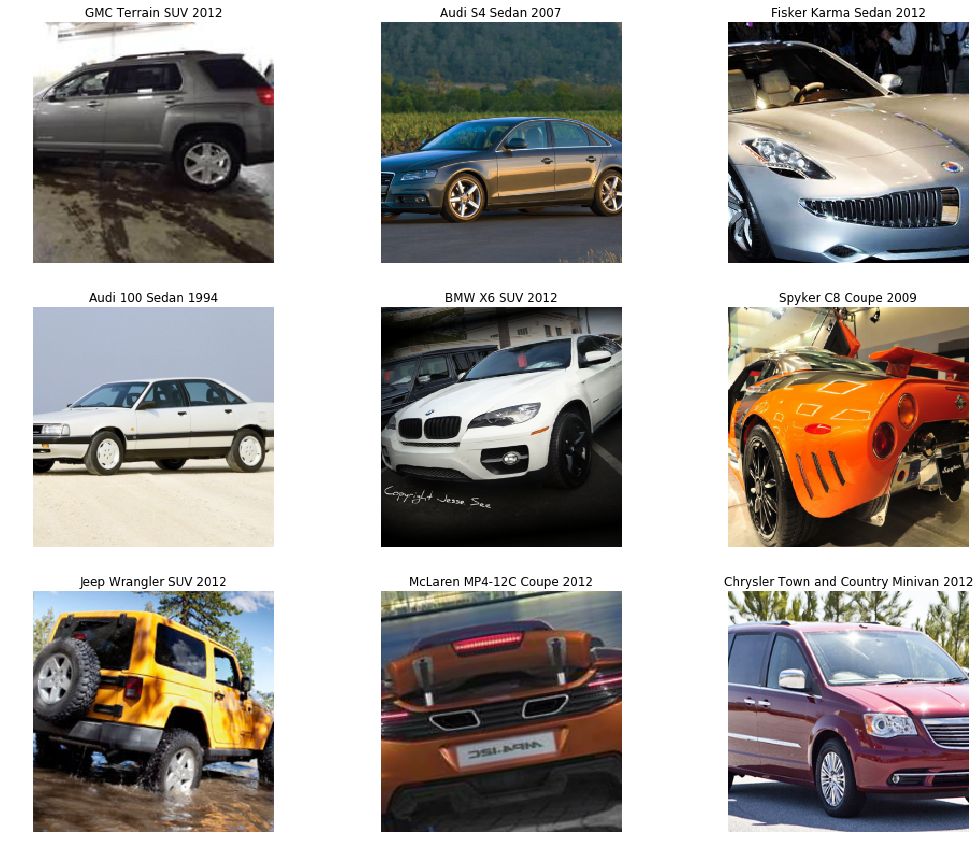

In [293]:
data.show_batch(rows=3, figsize=(15,12))

In [294]:
data.c, len(data.train_ds), len(data.valid_ds)


(196, 6516, 1628)

In [295]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/norvilr/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:08<00:00, 10378770.31it/s]


In [296]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,5.246243,4.122812,0.859951,00:46
1,3.902167,2.973322,0.689189,00:46
2,3.008107,2.506297,0.613636,00:46
3,2.478111,2.422665,0.582924,00:46


In [297]:
learn.unfreeze()

In [298]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


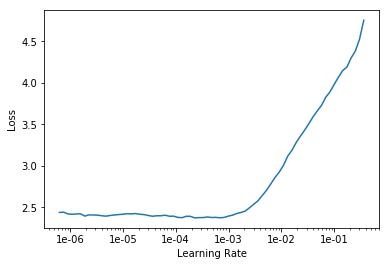

In [299]:
learn.recorder.plot()

In [301]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.009075,1.342061,0.345209,00:46
1,1.270342,1.507758,0.414619,00:46
2,0.935459,1.047532,0.286241,00:46
3,0.572422,0.770930,0.210074,00:46
4,0.355133,0.731964,0.201474,00:46


In [302]:
# error_rate still dropping, few more cycles
learn.fit_one_cycle(5, max_lr=slice(5e-5,5e-4,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.305802,0.750199,0.210074,00:47
1,0.397654,0.887203,0.245700,00:47
2,0.332529,0.784488,0.218059,00:47
3,0.213238,0.680550,0.191032,00:47
4,0.152631,0.664092,0.181818,00:47


In [303]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


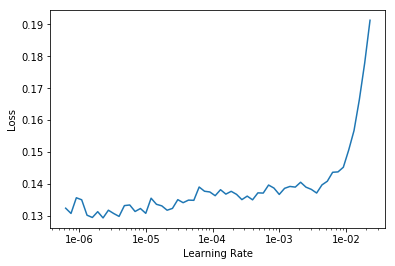

In [304]:
learn.lr_find()
learn.recorder.plot()

In [308]:
learn.fit_one_cycle(3, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.144983,0.666113,0.183047,00:45
1,0.144125,0.664480,0.184275,00:46
2,0.137182,0.661225,0.181818,00:46


In [310]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

In [312]:
data2 = ImageDataBunch.from_df(PATH, df, valid_pct=0.2, ds_tfms=get_transforms(),
                              size=299, num_workers=4).normalize(imagenet_stats)
learn.data = data2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


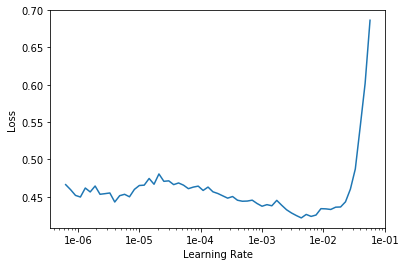

In [313]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [314]:
learn.fit_one_cycle(4, max_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.390984,0.244038,0.065111,00:54
1,0.460773,0.244105,0.067568,00:54
2,0.339940,0.197266,0.062039,00:53
3,0.237063,0.186706,0.053440,00:53


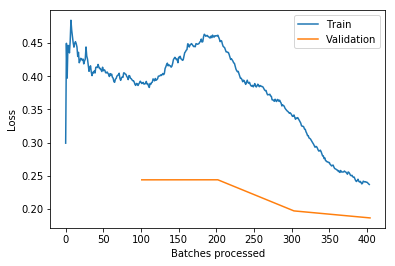

In [315]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


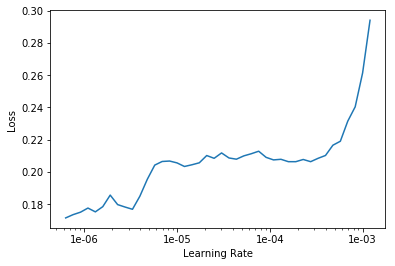

In [316]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [317]:
learn.fit_one_cycle(4, max_lr=slice(3e-6, 3e-3/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.213291,0.196111,0.051597,00:53
1,0.206041,0.200121,0.057125,00:53
2,0.165662,0.183734,0.055897,00:53
3,0.138683,0.179108,0.054054,00:53


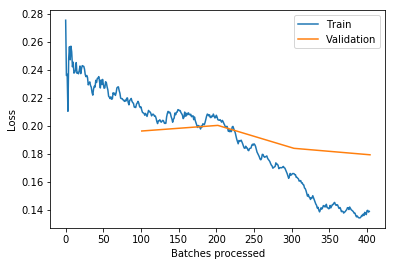

In [318]:
learn.recorder.plot_losses()

In [319]:
learn.save('229_all')

In [320]:
interp = ClassificationInterpretation.from_learner(learn)

/home/norvilr/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


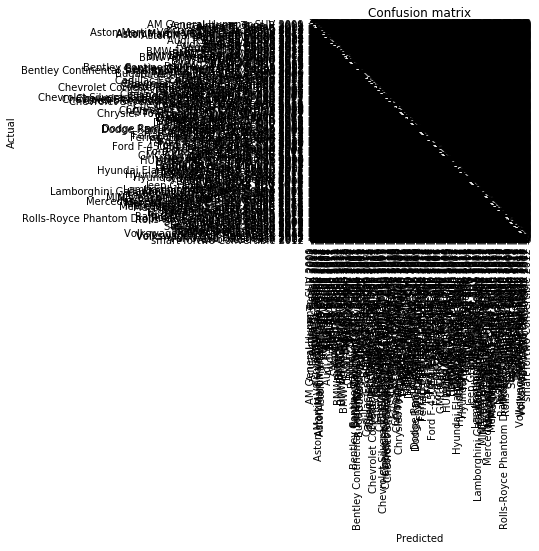

In [321]:
interp.plot_confusion_matrix()

In [322]:
%time log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

CPU times: user 2min 17s, sys: 3min 42s, total: 6min
Wall time: 1min 44s


TypeError: mean() missing 3 required positional argument: "dim", "keepdim", "dtype"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


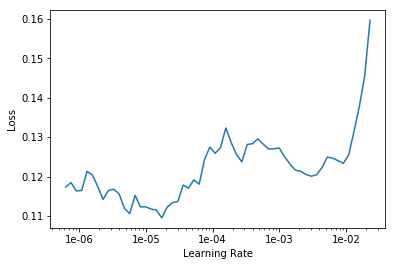

In [323]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [324]:
learn.fit_one_cycle(4, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.129223,0.178952,0.052826,00:52
1,0.133058,0.178400,0.052211,00:53
2,0.122846,0.178798,0.054668,00:53
3,0.124975,0.178595,0.052826,00:53


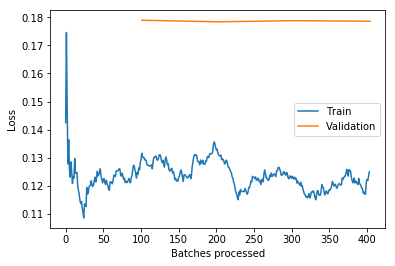

In [325]:
learn.recorder.plot_losses()